### Predicting Stock Prices

Usando el modelo LSTM (Long Short-Term memory) que es comunmente usado para en análisis de series temporales, como las predicciones de precios de acciones.

In [307]:
!pip install yfinance

In [308]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [309]:
# Load Data
company = "TSLA"
start = dt.datetime(2012,1,1)
end = dt.datetime(2023,1,1)
data = yf.download(company, start=start, end=end)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000


In [310]:
# Prepar Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(data["Close"].values.reshape(-1,1)) 

In [311]:
# Creación de datos de entrenamiento

prediction_days= 365 
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [312]:
# Construcción del modelo LSTM
model = Sequential() # Aquí se crea una instancia del modelo secuencial de Keras, que perimte aplicar capas de manera lineal.
model.add(LSTM(units=50, return_sequences = True, input_shape= (x_train.shape[1],1))) # Primera capa
model.add(Dropout(0.2)) # Se desconectan el 20% de los datos para el entrenamiento
model.add(LSTM(units=50, return_sequences = True,)) # Segunda capa
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = False,)) # Tercera capa
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Capa densa con una sola unidad. Esta capa generará la predicción, que sería el precio de cierra del día siguiente.

C:\Users\pauri\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [313]:
# Entrenamiento del modelo
model.compile(optimizer = "adam", loss ="mean_squared_error")
model.fit(x_train,y_train, epochs=25,batch_size=32)

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 0.0192
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 0.0025
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0023
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 0.0021
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0019
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.0021
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 0.0019
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 0.0018
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 0.0013
Epoch 10/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 0.0016
Epoch 11/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 0.0025
Epoch 12/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 0.0017
Epoch 13/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0015
Epoch 14/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0014
Epoch 15/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [314]:
# Evaluar la precisión del modelo
test_start = dt.datetime(2023,1,1)
test_end = dt.datetime.now()
test_data = yf.download(company, start= test_start, end= test_end)

[*********************100%***********************]  1 of 1 completed


In [315]:
# Preparación de los datos para realizar predicciones con el modelo previamente entrenado

actual_prices = test_data["Close"].values # Sirve para comparar las predicciones del modelo
total_dataset = pd.concat((data["Close"],test_data["Close"]),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [316]:
# Preparación de secuencias necesarias convirtiendolas en arrays de Numpy
x_test = []

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [317]:
# predicción de los precios según el modelo
predicted_prices = model.predict(x_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [318]:
# Desescalar los precios predecidos
predicted_prices = scaler.inverse_transform(predicted_prices)

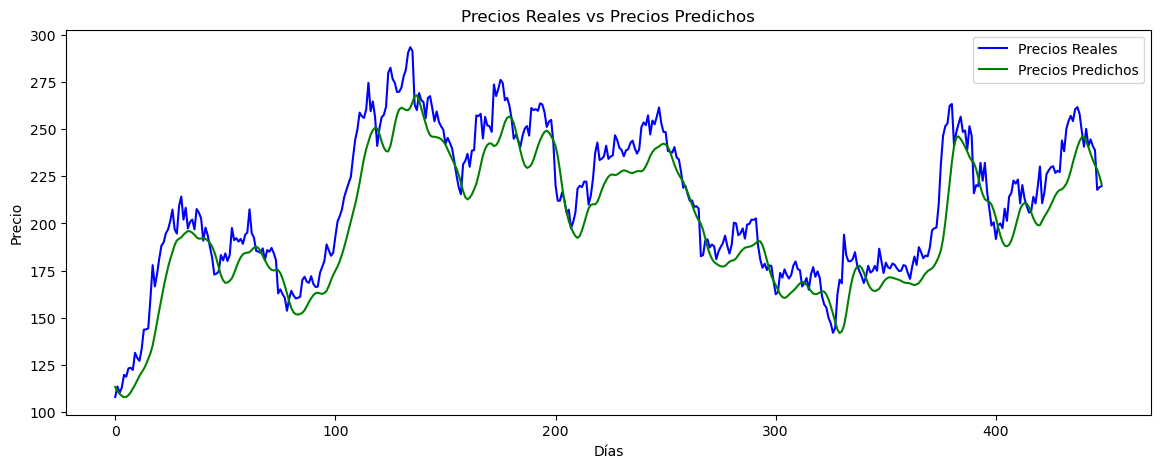

In [319]:
# Grafico 

plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color="blue", label="Precios Reales")
plt.plot(predicted_prices, color="green", label="Precios Predichos")
plt.title("Precios Reales vs Precios Predichos")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.show()

In [320]:
# Predecir precio del próximo dia
real_data= [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape (real_data,(real_data.shape[0],real_data.shape[1],1))

In [337]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction:{prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction:[[216.4081]]
